# without indicator and only raw price

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Signal processing
import pywt  # for wavelet transforms
from scipy.signal import argrelextrema  # for finding local minima/maxima

# Machine learning preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# TensorFlow / Keras - Deep Learning
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
file_path = r"C:\Users\amirhossein\Desktop\project of master\btcusd_1-min_data (1).csv"
df = pd.read_csv(file_path)

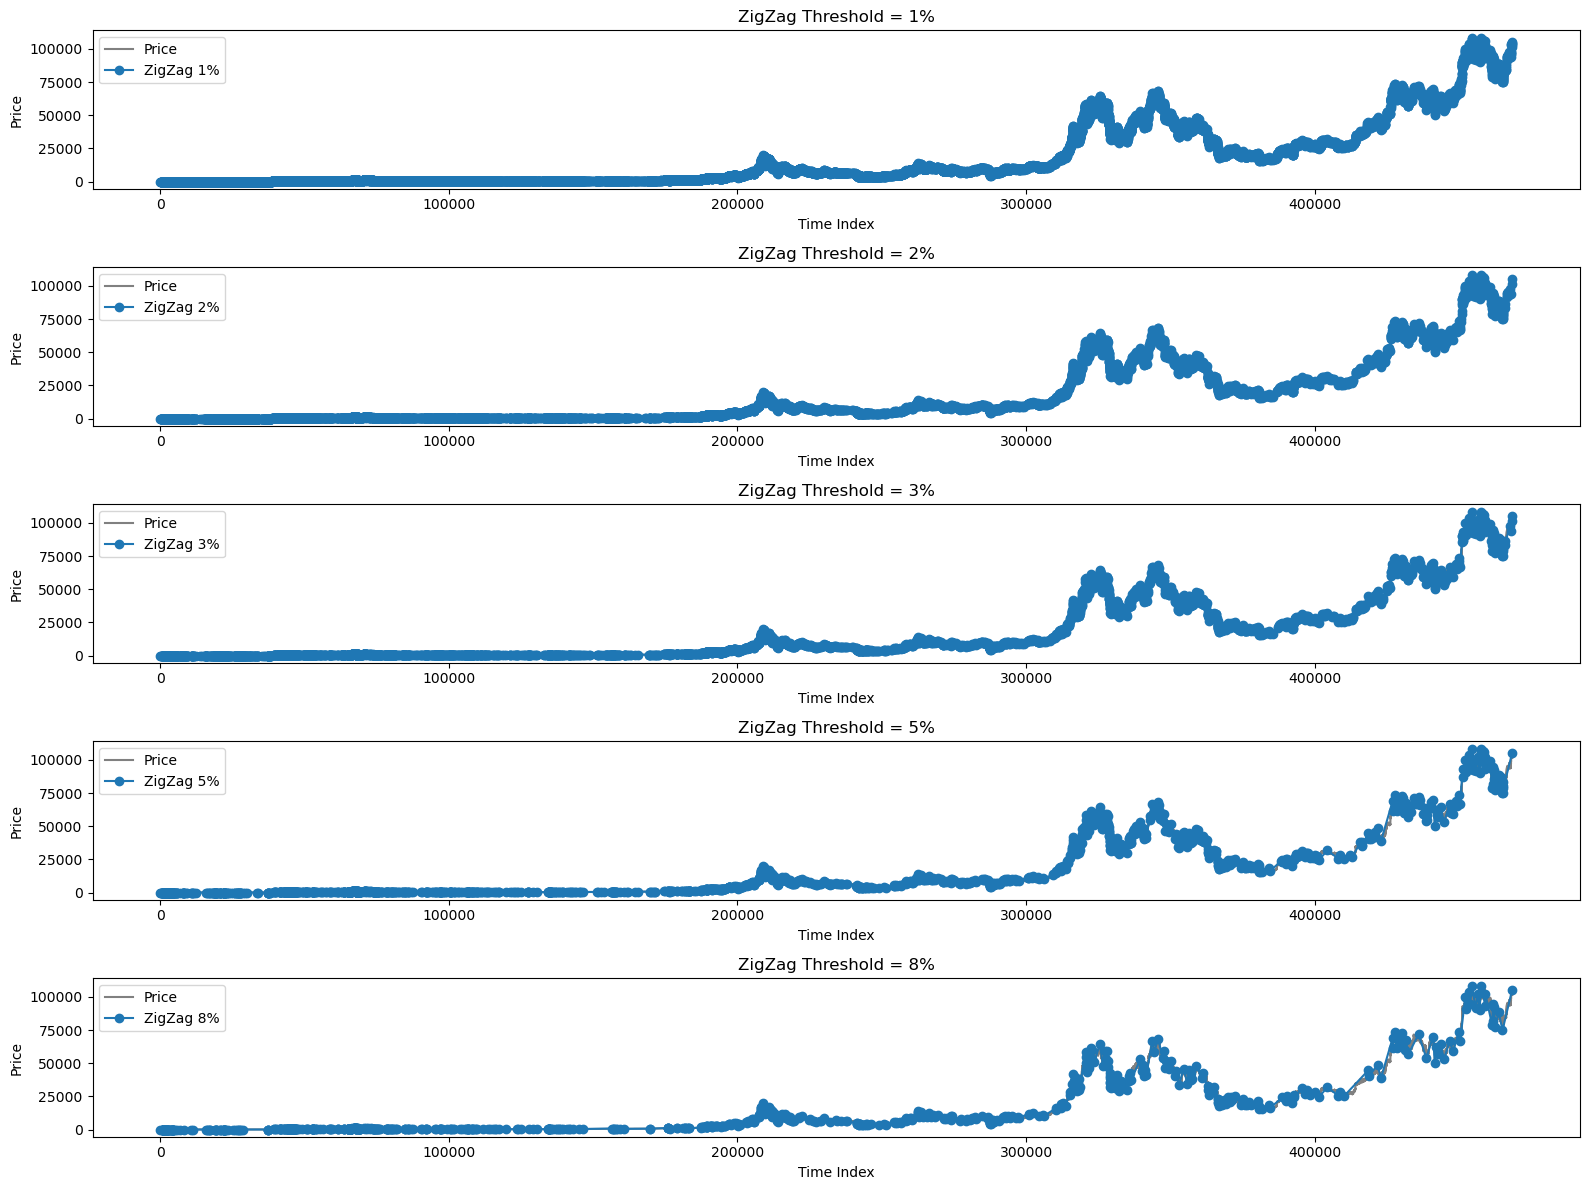

In [ ]:
if np.issubdtype(df['Timestamp'].dtype, np.number):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
else:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df = df.set_index('Timestamp')

df = df.resample('15min').mean().dropna()
df['Close'] = df['Close'].ffill()

price = df['Close'].values

def zigzag(price, percent):
    pivots = [0]
    direction = 0  # 0: unknown, 1: uptrend, -1: downtrend
    last_pivot = price[0]

    for i in range(1, len(price)):
        change = (price[i] - last_pivot) / last_pivot * 100

        if direction == 0:
            if abs(change) >= percent:
                direction = 1 if change > 0 else -1
                pivots.append(i)
                last_pivot = price[i]

        elif direction == 1:
            if price[i] > last_pivot:
                pivots[-1] = i
                last_pivot = price[i]
            elif ((last_pivot - price[i]) / last_pivot) * 100 >= percent:
                direction = -1
                pivots.append(i)
                last_pivot = price[i]

        elif direction == -1:
            if price[i] < last_pivot:
                pivots[-1] = i
                last_pivot = price[i]
            elif ((price[i] - last_pivot) / last_pivot) * 100 >= percent:
                direction = 1
                pivots.append(i)
                last_pivot = price[i]

    pivots = list(set(pivots))
    pivots.sort()
    return pivots

thresholds = [1, 2 , 3, 5, 8]

plt.figure(figsize=(16, 12))

for idx, th in enumerate(thresholds):
    pivots = zigzag(price, th)
    plt.subplot(len(thresholds), 1, idx + 1)
    plt.plot(price, label='Price', color='gray')
    plt.plot(pivots, price[pivots], marker='o', linestyle='-', label=f'ZigZag {th}%')
    plt.title(f'ZigZag Threshold = {th}%')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()

plt.tight_layout()
plt.show()


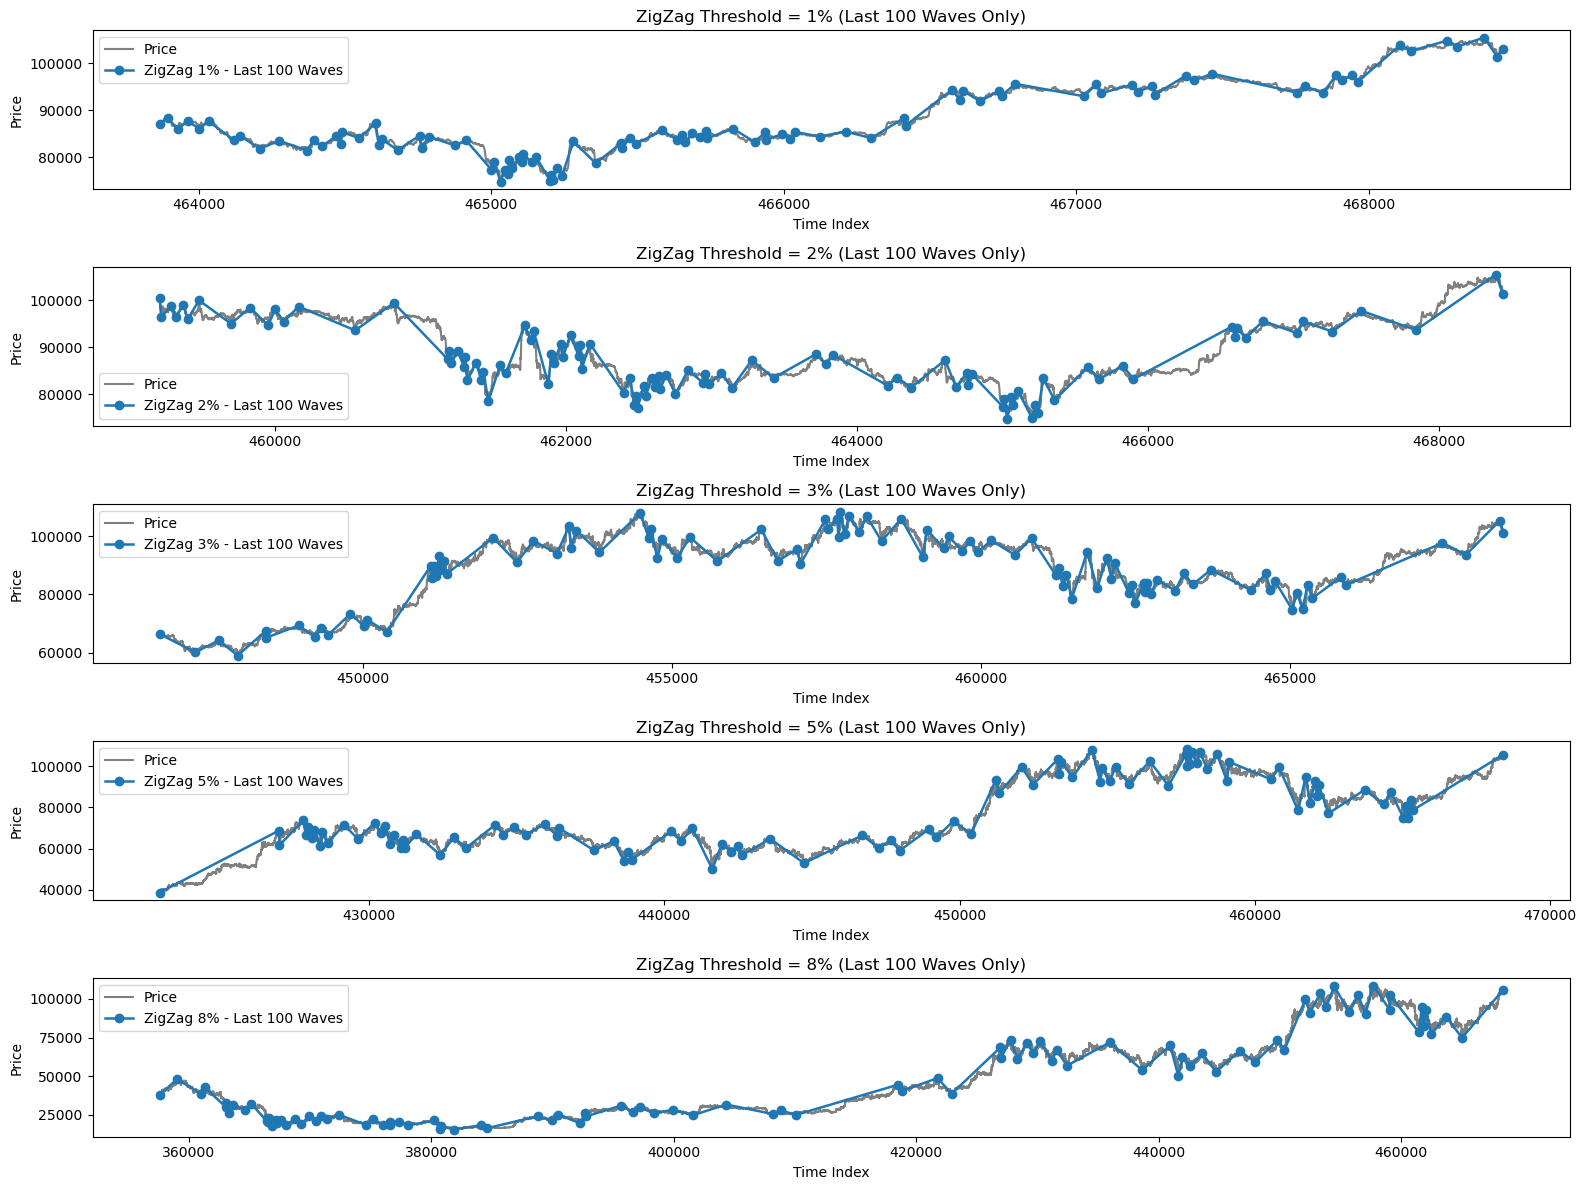

In [ ]:
price = df['Close'].values
# ZigZag function
def zigzag(price, percent):
    pivots = [0]
    direction = 0
    last_pivot = price[0]

    for i in range(1, len(price)):
        change = (price[i] - last_pivot) / last_pivot * 100

        if direction == 0:
            if abs(change) >= percent:
                direction = 1 if change > 0 else -1
                pivots.append(i)
                last_pivot = price[i]

        elif direction == 1:
            if price[i] > last_pivot:
                pivots[-1] = i
                last_pivot = price[i]
            elif ((last_pivot - price[i]) / last_pivot) * 100 >= percent:
                direction = -1
                pivots.append(i)
                last_pivot = price[i]

        elif direction == -1:
            if price[i] < last_pivot:
                pivots[-1] = i
                last_pivot = price[i]
            elif ((price[i] - last_pivot) / last_pivot) * 100 >= percent:
                direction = 1
                pivots.append(i)
                last_pivot = price[i]

    pivots = list(set(pivots))
    pivots.sort()
    return pivots


# Plotting
thresholds = [1, 2 , 3, 5, 8]
plt.figure(figsize=(16, 12))

for idx, th in enumerate(thresholds):
    pivots = zigzag(price, th)
    pivots_last_100 = pivots[-100:]

    # تعیین محدوده‌ای که این 100 موج آخر رخ داده‌اند
    start = pivots_last_100[0]
    end = pivots_last_100[-1]

    # بخش مربوط به اون محدوده از قیمت
    price_section = price[start:end + 1]
    x_range = np.arange(start, end + 1)

    plt.subplot(len(thresholds), 1, idx + 1)
    plt.plot(x_range, price_section, label='Price', color='gray')
    plt.plot(pivots_last_100, price[pivots_last_100], marker='o', linestyle='-', linewidth=1.8, label=f'ZigZag {th}% - Last 100 Waves')
    plt.title(f'ZigZag Threshold = {th}% (Last 100 Waves Only)')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()

plt.tight_layout()
plt.show()


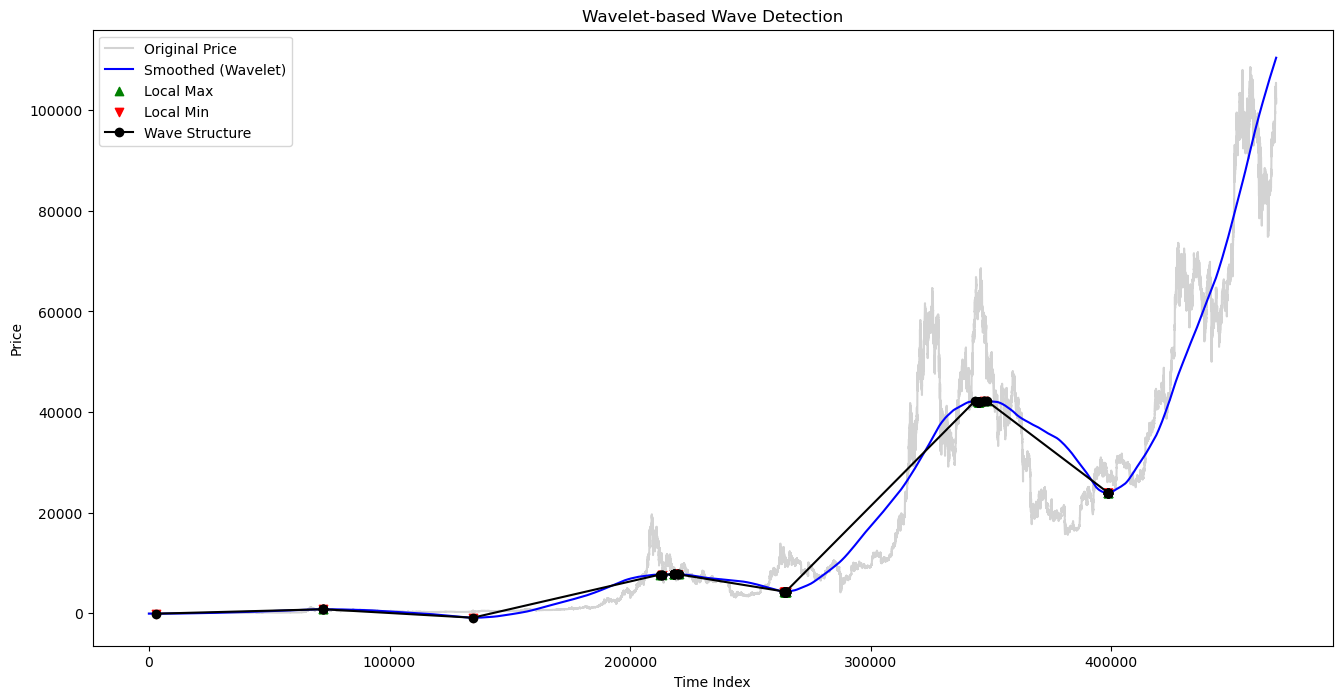

In [ ]:
def smooth_wavelet(price, wavelet='db4', level=1):
    coeff = pywt.wavedec(price, wavelet, mode="smooth")
    # Zero out detail coefficients to keep only approximation coefficients
    coeff[1:] = [np.zeros_like(c) for c in coeff[1:]]
    smooth_price = pywt.waverec(coeff, wavelet, mode="smooth")
    return smooth_price[:len(price)]


smoothed_price = smooth_wavelet(price, wavelet='db4', level=1)


# 3️⃣ Find local maxima and minima
order = 1  # You can adjust the sensitivity with this number
max_idx = argrelextrema(smoothed_price, np.greater, order=order)[0]
min_idx = argrelextrema(smoothed_price, np.less, order=order)[0]

pivot_idx = np.sort(np.concatenate((max_idx, min_idx)))


# 4️⃣ Plot detected waves
plt.figure(figsize=(16, 8))
plt.plot(price, label='Original Price', color='lightgray')
plt.plot(smoothed_price, label='Smoothed (Wavelet)', color='blue')

plt.scatter(max_idx, smoothed_price[max_idx], marker='^', color='green', label='Local Max')
plt.scatter(min_idx, smoothed_price[min_idx], marker='v', color='red', label='Local Min')

plt.plot(pivot_idx, smoothed_price[pivot_idx], linestyle='-', marker='o', color='black', label='Wave Structure')

plt.title('Wavelet-based Wave Detection')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


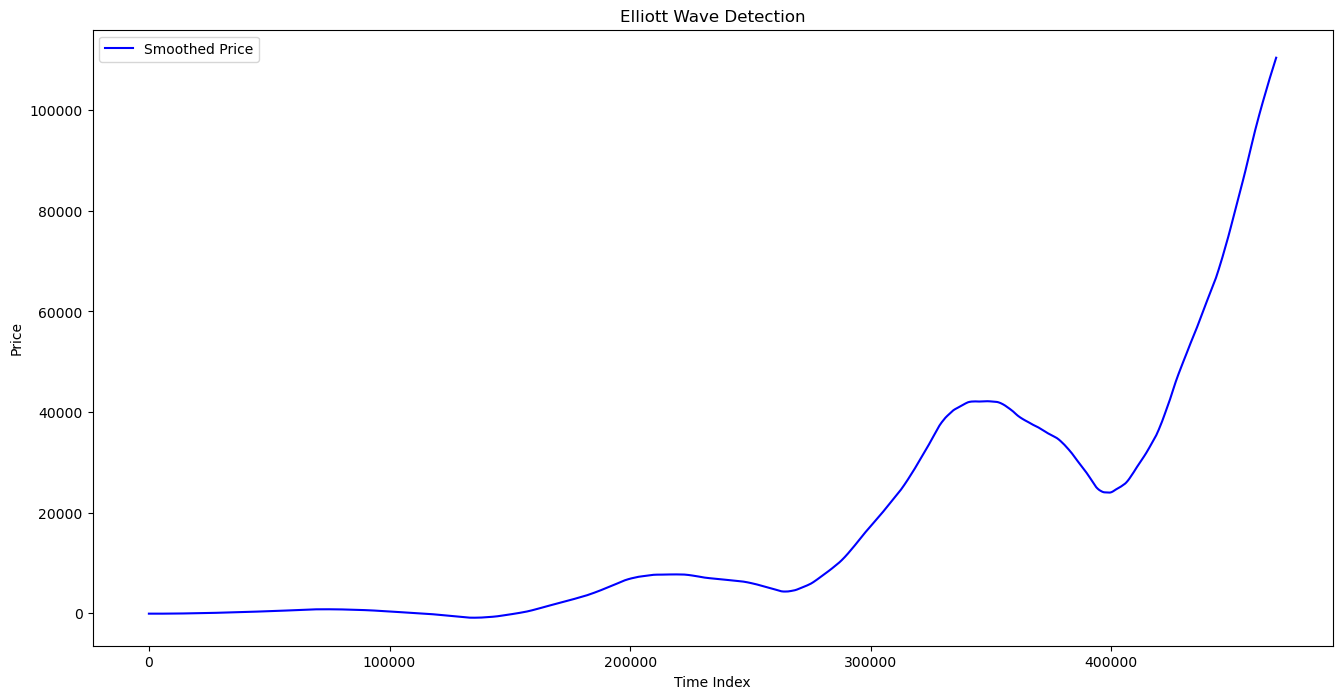

In [ ]:
# ✔️ Detect local maxima and minima
order = 3
max_idx = argrelextrema(smoothed_price, np.greater, order=order)[0]
min_idx = argrelextrema(smoothed_price, np.less, order=order)[0]
pivot_idx = np.sort(np.concatenate((max_idx, min_idx)))


# ✔️ Elliott wave labeling function with basic rules
def label_waves(pivot_idx, price):
    waves = []
    labels = []

    for i in range(len(pivot_idx) - 5):
        p = pivot_idx[i:i + 6]
        
        wave_1 = price[p[1]] - price[p[0]]
        wave_2 = price[p[2]] - price[p[1]]
        wave_3 = price[p[3]] - price[p[2]]
        wave_4 = price[p[4]] - price[p[3]]
        wave_5 = price[p[5]] - price[p[4]]

        valid = True

        # Rule: wave 2 should be smaller than wave 1
        if abs(wave_2) >= abs(wave_1):
            valid = False

        # Rule: wave 3 should be at least 80% of the max of wave 1 or wave 5
        if abs(wave_3) < 0.8 * max(abs(wave_1), abs(wave_5)):
            valid = False

        # Rule: wave 4 should not overlap wave 1
        if (wave_1 > 0 and price[p[4]] < price[p[1]]) or (wave_1 < 0 and price[p[4]] > price[p[1]]):
            valid = False

        if valid:
            waves.append(p)
            labels.append([1, 2, 3, 4, 5, 'End'])

    return waves, labels


# ✔️ Perform wave labeling
wave_structures, wave_labels = label_waves(pivot_idx, smoothed_price)


# ✔️ Plot detected Elliott waves
plt.figure(figsize=(16, 8))
plt.plot(smoothed_price, label='Smoothed Price', color='blue')

for wave, label in zip(wave_structures, wave_labels):
    plt.plot(wave, smoothed_price[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, smoothed_price[point] + 500, str(label[idx]), fontsize=8, color='black')

plt.title('Elliott Wave Detection')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


C:\Users\amirhossein\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


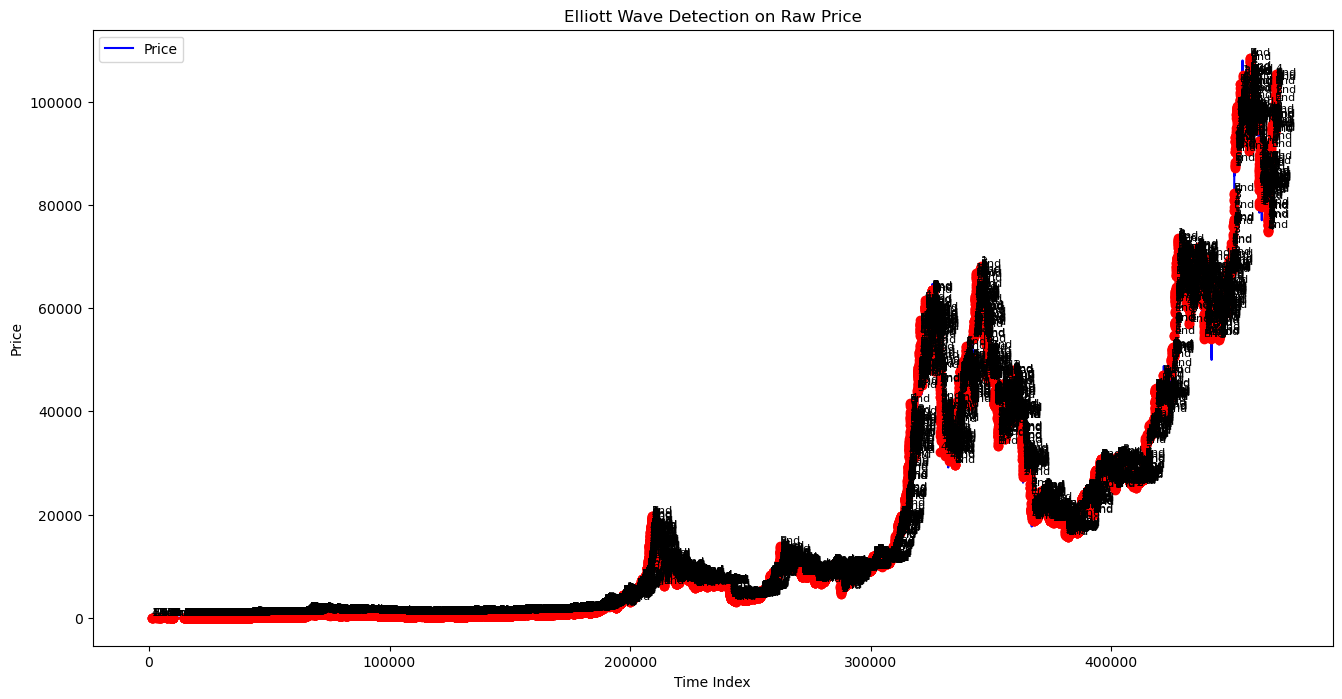

In [ ]:
# ✔️ Detect local maxima and minima on raw price data
order = 3  # Sensitivity level → you can adjust this to be lower or higher
max_idx = argrelextrema(price, np.greater, order=order)[0]
min_idx = argrelextrema(price, np.less, order=order)[0]
pivot_idx = np.sort(np.concatenate((max_idx, min_idx)))


# ✔️ Elliott wave labeling function on raw price
def label_waves(pivot_idx, price):
    waves = []
    labels = []

    for i in range(len(pivot_idx) - 5):
        p = pivot_idx[i:i + 6]
        
        wave_1 = price[p[1]] - price[p[0]]
        wave_2 = price[p[2]] - price[p[1]]
        wave_3 = price[p[3]] - price[p[2]]
        wave_4 = price[p[4]] - price[p[3]]
        wave_5 = price[p[5]] - price[p[4]]

        valid = True

        # Rule: wave 2 must be smaller than wave 1 in absolute value
        if abs(wave_2) >= abs(wave_1):
            valid = False

        # Rule: wave 3 must be greater than max of wave 1 or wave 5 in absolute value
        if abs(wave_3) <= max(abs(wave_1), abs(wave_5)):
            valid = False

        # Rule: wave 4 should not overlap wave 1
        if (wave_1 > 0 and price[p[4]] < price[p[1]]) or (wave_1 < 0 and price[p[4]] > price[p[1]]):
            valid = False

        if valid:
            waves.append(p)
            labels.append([1, 2, 3, 4, 5, 'End'])

    return waves, labels


# ✔️ Perform Elliott wave labeling
wave_structures, wave_labels = label_waves(pivot_idx, price)


# ✔️ Plot detected Elliott waves on raw price
plt.figure(figsize=(16, 8))
plt.plot(price, label='Price', color='blue')

for wave, label in zip(wave_structures, wave_labels):
    plt.plot(wave, price[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, price[point] + 500, str(label[idx]), fontsize=8, color='black')

plt.title('Elliott Wave Detection on Raw Price')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


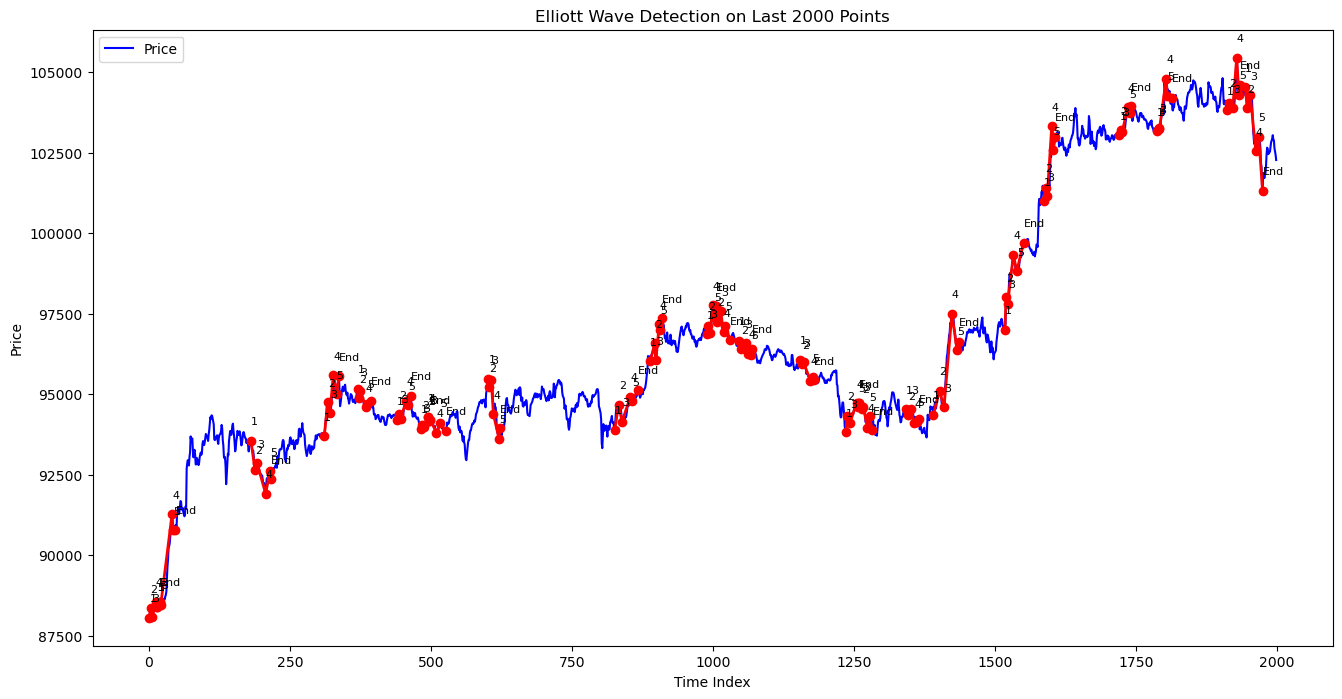

In [ ]:
# Select only the last 2000 points
start = len(price) - 2000
end = len(price)

price_section = price[start:end]
pivot_idx_section = pivot_idx[(pivot_idx >= start) & (pivot_idx <= end)] - start


# Perform wave labeling on the selected section
wave_structures, wave_labels = label_waves(pivot_idx_section, price_section)


# Plotting
plt.figure(figsize=(16, 8))
plt.plot(price_section, label='Price', color='blue')

for wave, label in zip(wave_structures, wave_labels):
    plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] + 500, str(label[idx]), fontsize=8, color='black')

plt.title('Elliott Wave Detection on Last 2000 Points')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


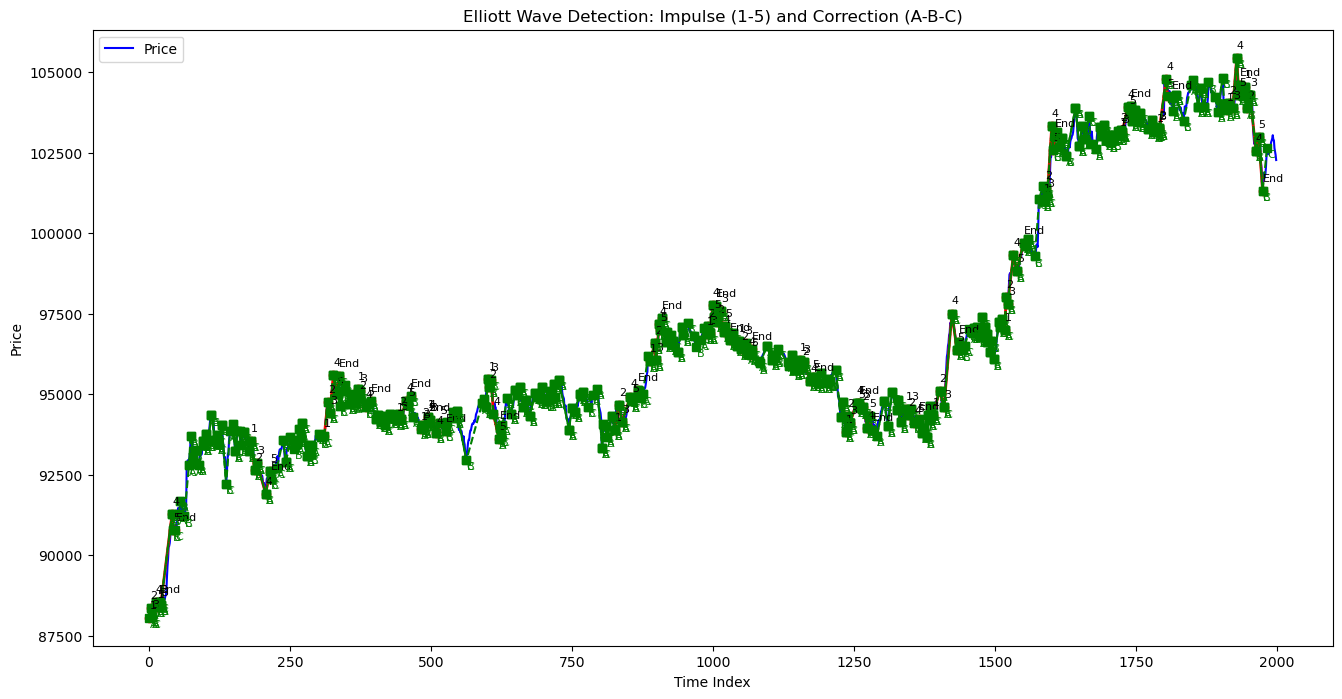

In [ ]:
# Corrective wave labeling function A-B-C
def label_correction_waves(pivot_idx, price):
    corrections = []
    labels = []

    for i in range(len(pivot_idx) - 2):
        p = pivot_idx[i:i + 3]
        
        wave_a = price[p[1]] - price[p[0]]
        wave_b = price[p[2]] - price[p[1]]

        # Rule for corrective wave: B moves opposite to A
        if (wave_a > 0 and wave_b < 0) or (wave_a < 0 and wave_b > 0):
            corrections.append(p)
            labels.append(['A', 'B', 'C'])

    return corrections, labels


# Run detection of A-B-C waves
correction_structures, correction_labels = label_correction_waves(pivot_idx_section, price_section)


# Plot impulse waves (1-5) and corrective waves (A-B-C)
plt.figure(figsize=(16, 8))
plt.plot(price_section, label='Price', color='blue')

# Impulse waves 1-5
for wave, label in zip(wave_structures, wave_labels):
    plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] + 300, str(label[idx]), fontsize=8, color='black')

# Corrective waves A-B-C
for wave, label in zip(correction_structures, correction_labels):
    plt.plot(wave, price_section[wave], linestyle='--', marker='s', linewidth=1.5, color='green')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] - 300, str(label[idx]), fontsize=8, color='green')

plt.title('Elliott Wave Detection: Impulse (1-5) and Correction (A-B-C)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


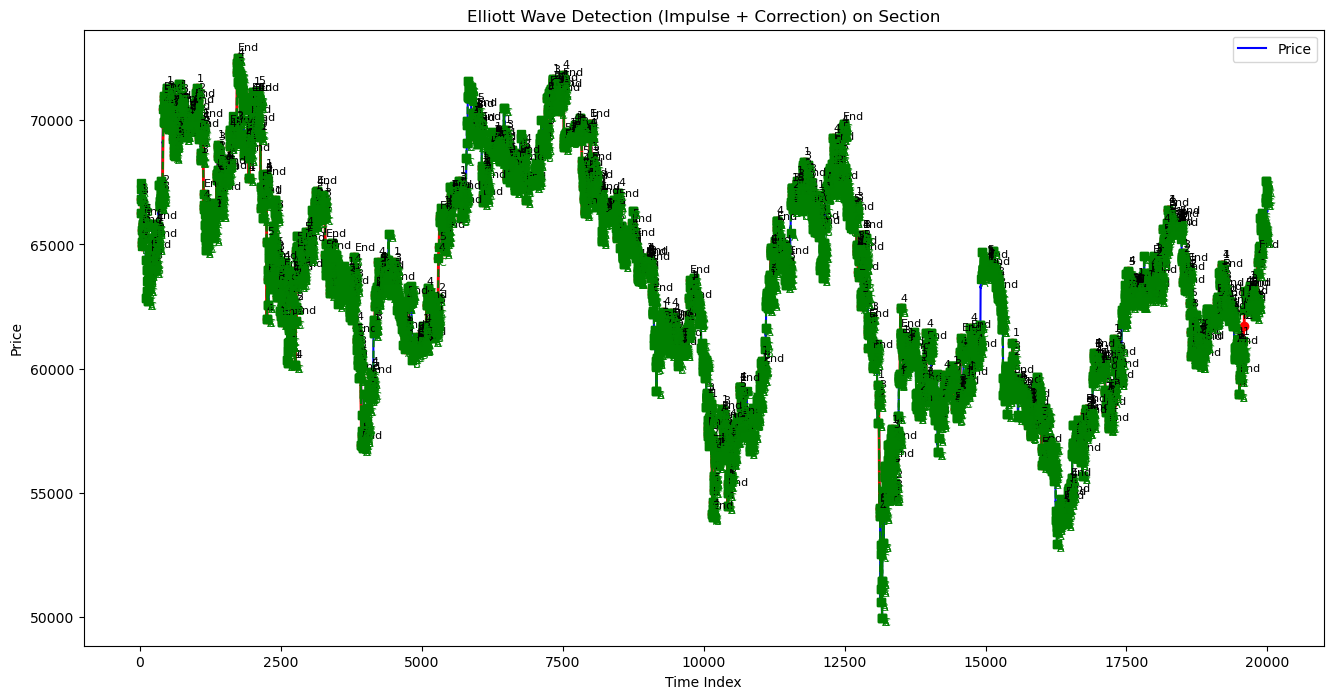

In [ ]:
# Select 2000 points before the last section
start = len(price) - 40000  # 2000 points before the last section
end = len(price) - 20000

price_section = price[start:end]
pivot_idx_section = pivot_idx[(pivot_idx >= start) & (pivot_idx <= end)] - start


# Impulse wave labeling
wave_structures, wave_labels = label_waves(pivot_idx_section, price_section)

# Corrective A-B-C wave labeling
correction_structures, correction_labels = label_correction_waves(pivot_idx_section, price_section)


# Plotting
plt.figure(figsize=(16, 8))
plt.plot(price_section, label='Price', color='blue')

# Impulse waves 1-5
for wave, label in zip(wave_structures, wave_labels):
    plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] + 300, str(label[idx]), fontsize=8, color='black')

# Corrective waves A-B-C
for wave, label in zip(correction_structures, correction_labels):
    plt.plot(wave, price_section[wave], linestyle='--', marker='s', linewidth=1.5, color='green')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] - 300, str(label[idx]), fontsize=8, color='green')

plt.title('Elliott Wave Detection (Impulse + Correction) on Section')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


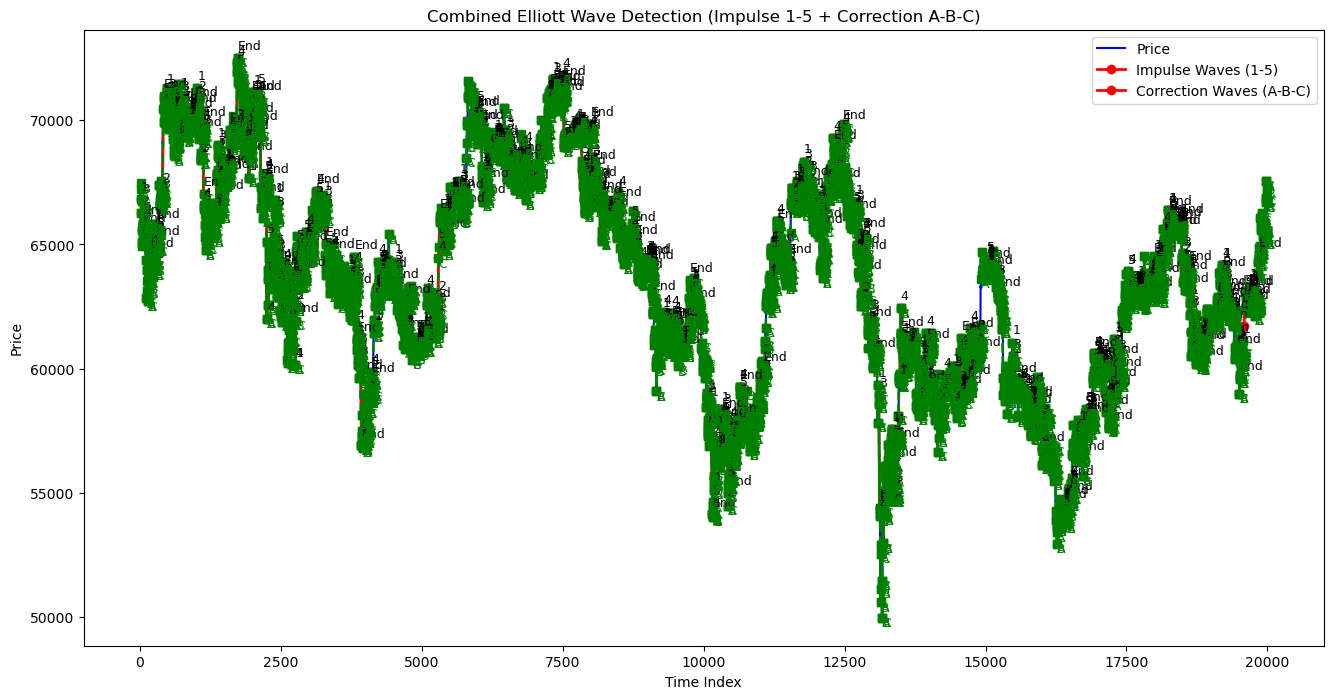

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(price_section, label='Price', color='blue')

# Impulse waves (1-5)
for wave, label in zip(wave_structures, wave_labels):
    plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] + 350, str(label[idx]), fontsize=9, color='black')

# Correction waves (A-B-C)
for wave, label in zip(correction_structures, correction_labels):
    plt.plot(wave, price_section[wave], linestyle='--', marker='s', linewidth=1.8, color='green')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] - 350, str(label[idx]), fontsize=9, color='green')

plt.title('Combined Elliott Wave Detection (Impulse 1-5 + Correction A-B-C)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(['Price', 'Impulse Waves (1-5)', 'Correction Waves (A-B-C)'])
plt.show()


In [ ]:
# Select a smaller range for higher resolution
start = len(price) - 4000  
end = len(price) - 2000

price_section = price[start:end]
pivot_idx_section = pivot_idx[(pivot_idx >= start) & (pivot_idx <= end)] - start


In [ ]:
# Impulse waves
wave_structures, wave_labels = label_waves(pivot_idx_section, price_section)

# Corrective waves
correction_structures, correction_labels = label_correction_waves(pivot_idx_section, price_section)


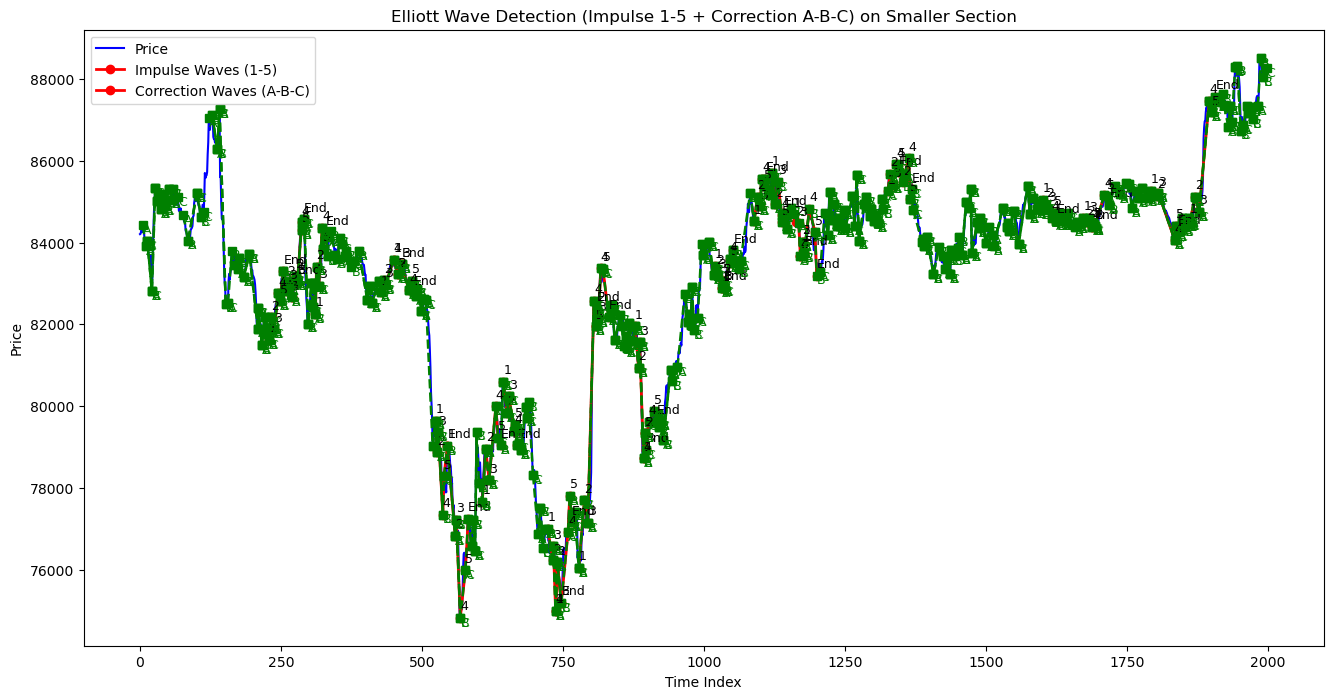

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(price_section, label='Price', color='blue')

# Impulse waves (1-5)
for wave, label in zip(wave_structures, wave_labels):
    plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] + 200, str(label[idx]), fontsize=9, color='black')

# Corrective waves (A-B-C)
for wave, label in zip(correction_structures, correction_labels):
    plt.plot(wave, price_section[wave], linestyle='--', marker='s', linewidth=1.8, color='green')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] - 200, str(label[idx]), fontsize=9, color='green')

plt.title('Elliott Wave Detection (Impulse 1-5 + Correction A-B-C) on Smaller Section')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(['Price', 'Impulse Waves (1-5)', 'Correction Waves (A-B-C)'])
plt.show()


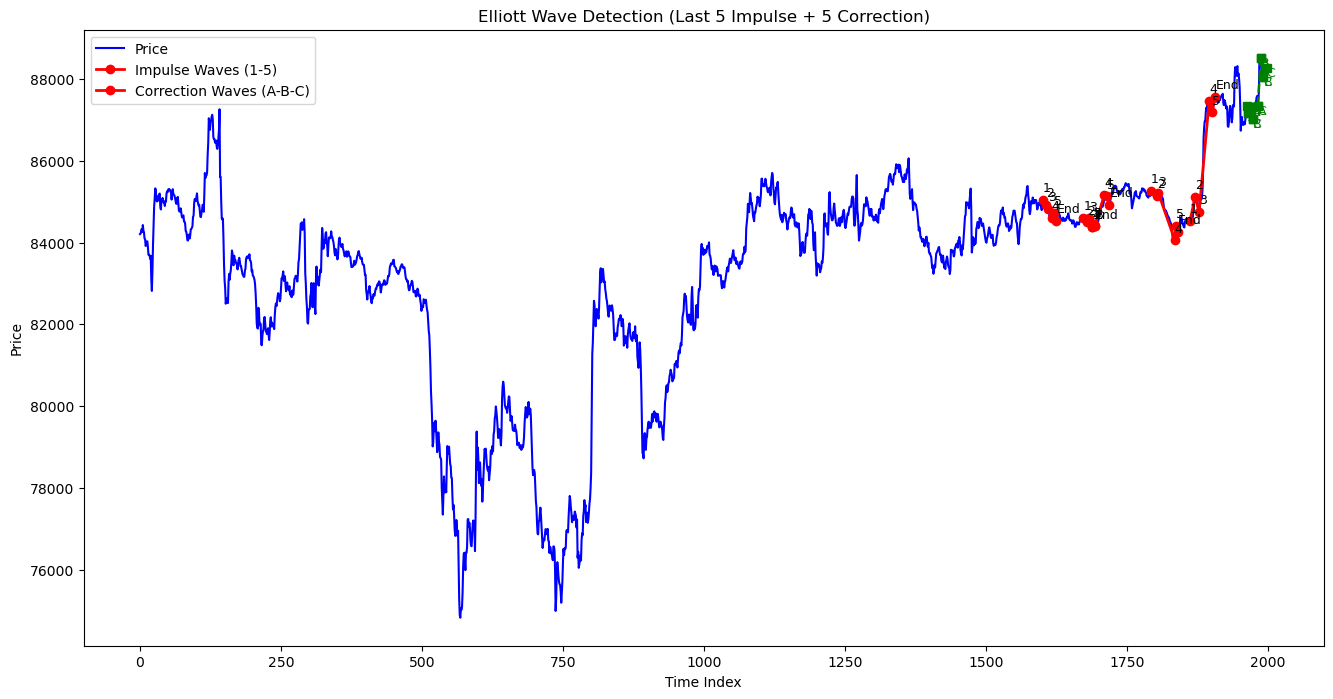

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(price_section, label='Price', color='blue')

# ✔️ Impulse waves — only the last 5 waves
if len(wave_structures) > 0:
    last_impulses = wave_structures[-5:]  # Last 5 impulse waves
    last_labels = wave_labels[-5:]

    for wave, label in zip(last_impulses, last_labels):
        plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
        for idx, point in enumerate(wave):
            plt.text(point, price_section[point] + 200, str(label[idx]), fontsize=9, color='black')

# ✔️ Corrective waves A-B-C — only the last 5 waves
if len(correction_structures) > 0:
    last_corrections = correction_structures[-5:]  # Last 5 correction waves
    last_c_labels = correction_labels[-5:]

    for wave, label in zip(last_corrections, last_c_labels):
        plt.plot(wave, price_section[wave], linestyle='--', marker='s', linewidth=1.8, color='green')
        for idx, point in enumerate(wave):
            plt.text(point, price_section[point] - 200, str(label[idx]), fontsize=9, color='green')

plt.title('Elliott Wave Detection (Last 5 Impulse + 5 Correction)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(['Price', 'Impulse Waves (1-5)', 'Correction Waves (A-B-C)'])
plt.show()


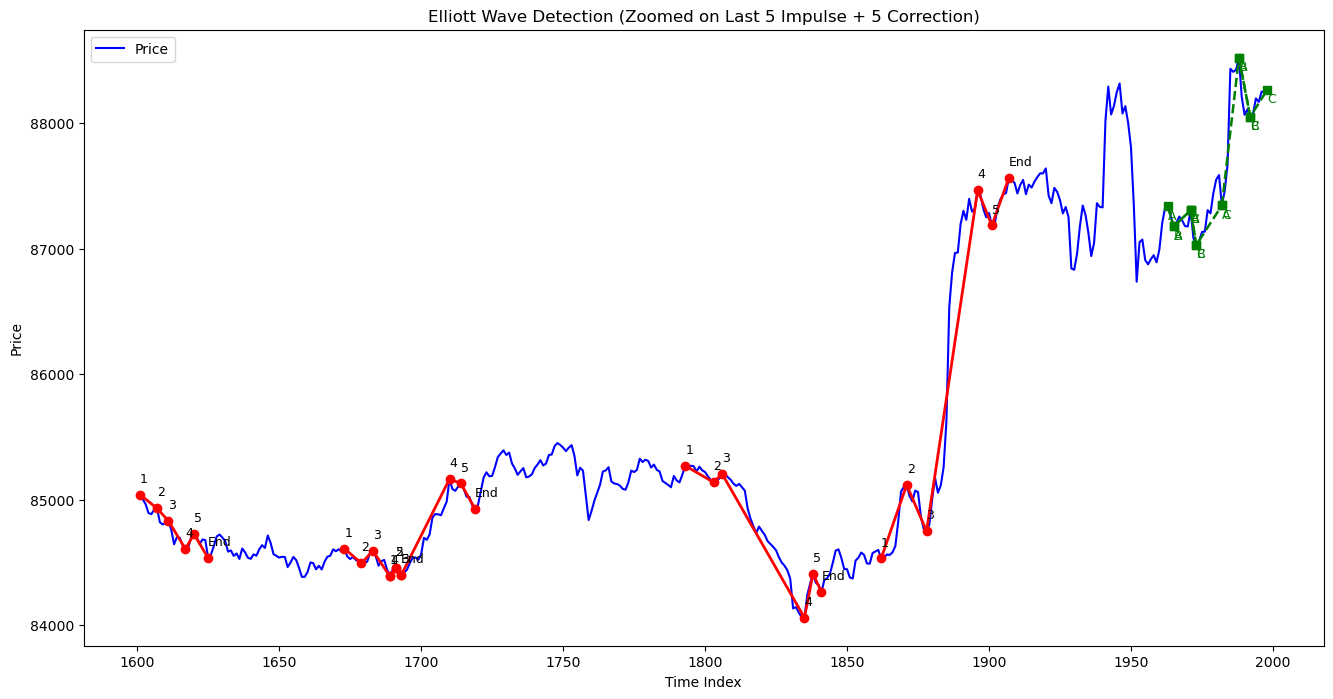

In [ ]:
# Find the start and end index range of the last waves
all_points = []

for wave in last_impulses:
    all_points.extend(wave)

for wave in last_corrections:
    all_points.extend(wave)

min_idx = min(all_points)
max_idx = max(all_points)

# Extract the price data for the wave range only
price_focus = price_section[min_idx:max_idx + 1]
x_range = np.arange(min_idx, max_idx + 1)

# Plot only the last waves on the focused section
plt.figure(figsize=(16, 8))
plt.plot(x_range, price_focus, label='Price', color='blue')

# Impulse waves
for wave, label in zip(last_impulses, last_labels):
    plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] + 100, str(label[idx]), fontsize=9, color='black')

# Corrective waves
for wave, label in zip(last_corrections, last_c_labels):
    plt.plot(wave, price_section[wave], linestyle='--', marker='s', linewidth=1.8, color='green')
    for idx, point in enumerate(wave):
        plt.text(point, price_section[point] - 100, str(label[idx]), fontsize=9, color='green')

plt.title('Elliott Wave Detection (Zoomed on Last 5 Impulse + 5 Correction)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
def label_waves_flexible(pivot_idx, price):
    waves = []
    labels = []

    if len(pivot_idx) < 6:
        print("Not enough pivot points")
        return [], []

    for i in range(len(pivot_idx) - 5):
        p = pivot_idx[i:i + 6]
        if max(p) >= len(price):
            continue

        p0, p1, p2, p3, p4, p5 = p
        wave_1 = price[p1] - price[p0]
        wave_2 = price[p2] - price[p1]
        wave_3 = price[p3] - price[p2]
        wave_4 = price[p4] - price[p3]
        wave_5 = price[p5] - price[p4]

        valid = True

        if abs(wave_2) >= abs(wave_1):
            valid = False

        if (wave_1 * wave_3 <= 0) or (abs(wave_3) < abs(wave_1) * 0.5):
            valid = False

        if wave_3 * wave_4 >= 0:
            valid = False

        if (wave_1 > 0 and price[p4] < price[p1]) or (wave_1 < 0 and price[p4] > price[p1]):
            valid = False

        if wave_5 * wave_3 <= 0:
            valid = False

        directions = [np.sign(price[p1] - price[p0]),
                      np.sign(price[p2] - price[p1]),
                      np.sign(price[p3] - price[p2]),
                      np.sign(price[p4] - price[p3]),
                      np.sign(price[p5] - price[p4])]
        if len(set(directions)) < 2:
            valid = False

        if valid:
            waves.append(p)
            labels.append([1, 2, 3, 4, 5, 'End'])

    return waves, labels


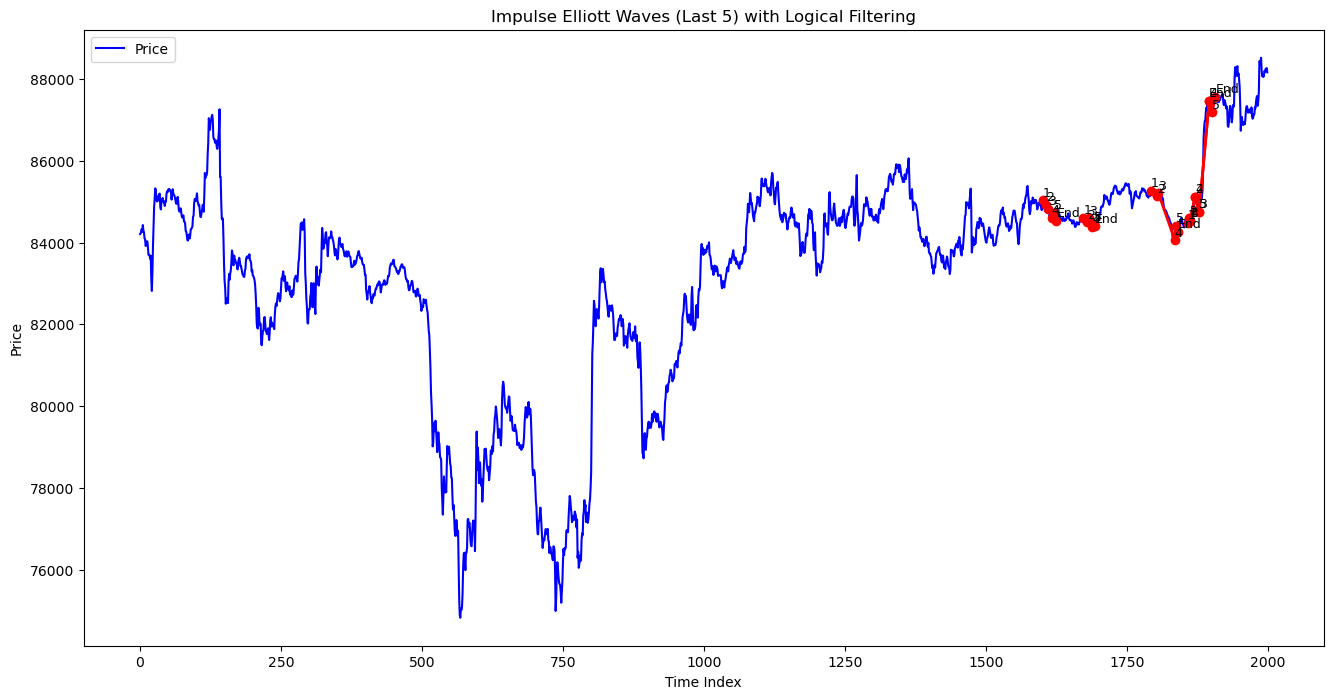

In [ ]:
def label_waves_flexible(pivot_idx, price):
    waves = []
    labels = []

    if len(pivot_idx) < 6:
        print("Not enough pivot points")
        return [], []

    for i in range(len(pivot_idx) - 5):
        p = pivot_idx[i:i + 6]
        if max(p) >= len(price):
            continue

        p0, p1, p2, p3, p4, p5 = p
        wave_1 = price[p1] - price[p0]
        wave_2 = price[p2] - price[p1]
        wave_3 = price[p3] - price[p2]
        wave_4 = price[p4] - price[p3]
        wave_5 = price[p5] - price[p4]

        valid = True

        # Wave 2 should not retrace more than Wave 1
        if abs(wave_2) >= abs(wave_1):
            valid = False

        # Wave 3 must be in the same direction and large enough compared to Wave 1
        if (wave_1 * wave_3 <= 0) or (abs(wave_3) < abs(wave_1) * 0.5):
            valid = False

        # Wave 4 should be in the opposite direction of Wave 3
        if wave_3 * wave_4 >= 0:
            valid = False

        # Wave 4 should not overlap Wave 1 territory
        if (wave_1 > 0 and price[p4] < price[p1]) or (wave_1 < 0 and price[p4] > price[p1]):
            valid = False

        # Wave 5 should be in the same direction as Wave 3
        if wave_5 * wave_3 <= 0:
            valid = False

        # Must have at least two different directions across the waves
        directions = [np.sign(price[p1] - price[p0]),
                      np.sign(price[p2] - price[p1]),
                      np.sign(price[p3] - price[p2]),
                      np.sign(price[p4] - price[p3]),
                      np.sign(price[p5] - price[p4])]
        if len(set(directions)) < 2:
            valid = False

        if valid:
            waves.append(p)
            labels.append([1, 2, 3, 4, 5, 'End'])

    return waves, labels


# Run new wave labeling
wave_structures, wave_labels = label_waves_flexible(pivot_idx_section, price_section)

# Plot only the last 5 impulse waves
plt.figure(figsize=(16, 8))
plt.plot(price_section, label='Price', color='blue')

if len(wave_structures) > 0:
    last_impulses = wave_structures[-5:]
    last_labels = wave_labels[-5:]

    for wave, label in zip(last_impulses, last_labels):
        plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
        for idx, point in enumerate(wave):
            plt.text(point, price_section[point] + 100, str(label[idx]), fontsize=9, color='black')

plt.title('Impulse Elliott Waves (Last 5) with Logical Filtering')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def detect_and_plot_elliott(price_section, pivot_idx_section, n_last=5):
    # Impulse wave detection
    def label_waves_flexible(pivot_idx, price):
        waves = []
        labels = []

        if len(pivot_idx) < 6:
            return [], []

        for i in range(len(pivot_idx) - 5):
            p = pivot_idx[i:i + 6]
            if max(p) >= len(price):
                continue

            p0, p1, p2, p3, p4, p5 = p
            wave_1 = price[p1] - price[p0]
            wave_2 = price[p2] - price[p1]
            wave_3 = price[p3] - price[p2]
            wave_4 = price[p4] - price[p3]
            wave_5 = price[p5] - price[p4]

            valid = True

            if abs(wave_2) >= abs(wave_1):
                valid = False
            if (wave_1 * wave_3 <= 0) or (abs(wave_3) < abs(wave_1) * 0.5):
                valid = False
            if wave_3 * wave_4 >= 0:
                valid = False
            if (wave_1 > 0 and price[p4] < price[p1]) or (wave_1 < 0 and price[p4] > price[p1]):
                valid = False
            if wave_5 * wave_3 <= 0:
                valid = False

            directions = [np.sign(price[p1] - price[p0]),
                          np.sign(price[p2] - price[p1]),
                          np.sign(price[p3] - price[p2]),
                          np.sign(price[p4] - price[p3]),
                          np.sign(price[p5] - price[p4])]
            if len(set(directions)) < 2:
                valid = False

            if valid:
                waves.append(p)
                labels.append([1, 2, 3, 4, 5, 'End'])

        return waves, labels

    # Corrective wave detection — only after valid impulse
    def label_correction_waves_strict(pivot_idx, price, impulse_waves):
        corrections = []
        labels = []

        if not impulse_waves:
            return [], []

        impulse_ends = [wave[5] for wave in impulse_waves if wave[5] < len(price) - 3]

        for end in impulse_ends:
            for i in range(end + 1, len(pivot_idx) - 2):
                p = pivot_idx[i:i + 3]
                if max(p) >= len(price):
                    continue

                a = price[p[1]] - price[p[0]]
                b = price[p[2]] - price[p[1]]

                if a * b >= 0:
                    continue

                c = price[p[2]] - price[p[0]]
                if c * a <= 0:
                    continue

                corrections.append(p)
                labels.append(['A', 'B', 'C'])
                break  # Only take the first correction after each impulse

        return corrections, labels

    # Run wave detection
    wave_structures, wave_labels = label_waves_flexible(pivot_idx_section, price_section)
    correction_structures, correction_labels = label_correction_waves_strict(
        pivot_idx_section, price_section, wave_structures
    )

    # Plot results
    plt.figure(figsize=(16, 8))
    plt.plot(price_section, label='Price', color='blue')

    # Plot impulse waves
    if len(wave_structures) > 0:
        for wave, label in zip(wave_structures[-n_last:], wave_labels[-n_last:]):
            plt.plot(wave, price_section[wave], linestyle='-', marker='o', linewidth=2, color='red')
            for idx, point in enumerate(wave):
                plt.text(point, price_section[point] + 100, str(label[idx]), fontsize=9, color='black')

    # Plot corrective waves
    if len(correction_structures) > 0:
        for wave, label in zip(correction_structures[-n_last:], correction_labels[-n_last:]):
            plt.plot(wave, price_section[wave], linestyle='--', marker='s', linewidth=1.8, color='green')
            for idx, point in enumerate(wave):
                plt.text(point, price_section[point] - 100, str(label[idx]), fontsize=9, color='green')

    plt.title('Elliott Wave Detection (Impulse 1-5 + Correction A-B-C)')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


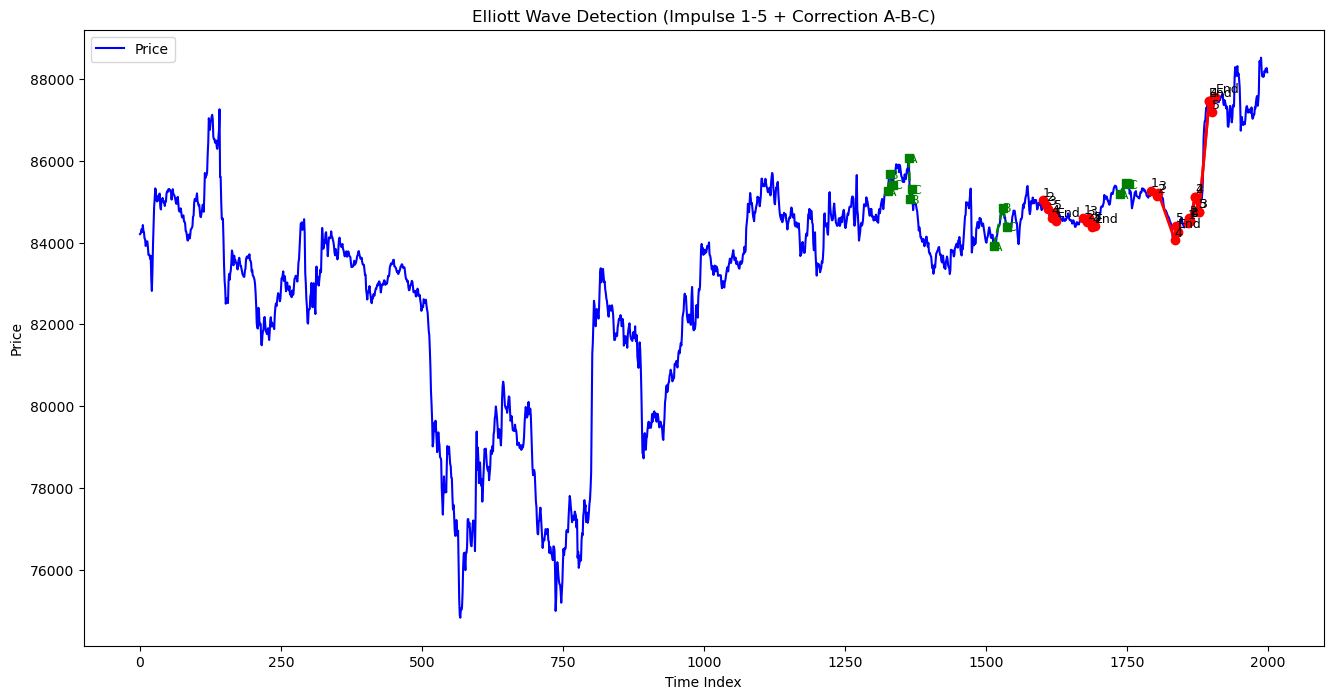

In [ ]:
detect_and_plot_elliott(price_section, pivot_idx_section, n_last=5)

In [ ]:
#   Function to label points based on impulse and corrective waves
def label_wave_points(price_len, wave_structures, wave_labels, correction_structures, correction_labels):
    labels = np.array(['None'] * price_len)

    # Label impulse waves (1 to 5)
    for wave, label in zip(wave_structures, wave_labels):
        for i in range(5):  # Only 1 to 5, not "End"
            start, end = wave[i], wave[i + 1]
            if end >= price_len:
                continue
            labels[start:end + 1] = str(label[i])

    # Label corrective waves (A to C)
    for wave, label in zip(correction_structures, correction_labels):
        for i in range(2):  # A→B and B→C
            start, end = wave[i], wave[i + 1]
            if end >= price_len:
                continue
            labels[start:end + 1] = label[i]

    return labels


#  Function to build dataset (X: price windows, y: wave label)
def build_wave_dataset(price_array, label_array, window_size=60):
    X = []
    y = []

    for i in range(len(price_array) - window_size):
        window = price_array[i:i + window_size]
        label = label_array[i + window_size - 1]

        if label != 'None':
            X.append(window)
            y.append(label)

    return np.array(X), np.array(y)


In [ ]:
# 1️⃣ Generate label for each point:
point_labels = label_wave_points(
    len(price_section),
    wave_structures, wave_labels,
    correction_structures, correction_labels
)

# 2️⃣ Build dataset X and y for model training:
X, y = build_wave_dataset(price_section, point_labels, window_size=60)

# 3️⃣ Check output:
print(f'X shape: {X.shape}, y shape: {y.shape}')
print('Sample of labels:', np.unique(y))


X shape: (1923, 60), y shape: (1923,)
Sample of labels: ['1' '2' 'A' 'B']


In [ ]:
# 1️ Load and prepare data
def load_and_prepare_data(file_path, resample_interval='15min'):
    df = pd.read_csv(file_path)

    # Convert timestamp column
    if np.issubdtype(df['Timestamp'].dtype, np.number):
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    else:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    df.set_index('Timestamp', inplace=True)
    df = df.resample(resample_interval).mean().dropna()
    df['Close'] = df['Close'].ffill()  # Forward fill for any missing close values

    return df['Close'].values, df.index


# 2️ Extract peak/trough points from price
def get_pivot_indices(price, order=3):
    max_idx = argrelextrema(price, np.greater, order=order)[0]
    min_idx = argrelextrema(price, np.less, order=order)[0]
    return np.sort(np.concatenate((max_idx, min_idx)))


# 3️ Execute all steps up to this point
file_path = r"C:\Users\amirhossein\Desktop\project of master\btcusd_1-min_data (1).csv"

price_full, index_full = load_and_prepare_data(file_path)

# Select a reasonable segment of price data for wave analysis
start = len(price_full) - 400000
end = len(price_full) - 100000
price_section = price_full[start:end]
pivot_idx_section = get_pivot_indices(price_section, order=3)

print(" Data is ready.")
print(" Length of price_section:", len(price_section))
print(" Number of pivot points:", len(pivot_idx_section))


✅ Data is ready.
✅ Length of price_section: 300000
✅ Number of pivot points: 59789


In [ ]:
# Impulse wave labeling function
def label_waves_flexible(pivot_idx, price):
    waves = []
    labels = []

    if len(pivot_idx) < 6:
        return [], []

    for i in range(len(pivot_idx) - 5):
        p = pivot_idx[i:i + 6]
        if max(p) >= len(price):
            continue

        p0, p1, p2, p3, p4, p5 = p
        wave_1 = price[p1] - price[p0]
        wave_2 = price[p2] - price[p1]
        wave_3 = price[p3] - price[p2]
        wave_4 = price[p4] - price[p3]
        wave_5 = price[p5] - price[p4]

        valid = True

        if abs(wave_2) >= abs(wave_1):
            valid = False
        if (wave_1 * wave_3 <= 0) or (abs(wave_3) < abs(wave_1) * 0.5):
            valid = False
        if wave_3 * wave_4 >= 0:
            valid = False
        if (wave_1 > 0 and price[p4] < price[p1]) or (wave_1 < 0 and price[p4] > price[p1]):
            valid = False
        if wave_5 * wave_3 <= 0:
            valid = False

        directions = [np.sign(price[p1] - price[p0]),
                      np.sign(price[p2] - price[p1]),
                      np.sign(price[p3] - price[p2]),
                      np.sign(price[p4] - price[p3]),
                      np.sign(price[p5] - price[p4])]
        if len(set(directions)) < 2:
            valid = False

        if valid:
            waves.append(p)
            labels.append([1, 2, 3, 4, 5, 'End'])

    return waves, labels


# Strict corrective wave labeling function (only after impulse)
def label_correction_waves_strict(pivot_idx, price, impulse_waves):
    corrections = []
    labels = []

    if not impulse_waves:
        return [], []

    impulse_ends = [wave[5] for wave in impulse_waves if wave[5] < len(price) - 3]

    for end in impulse_ends:
        for i in range(end + 1, len(pivot_idx) - 2):
            p = pivot_idx[i:i + 3]
            if max(p) >= len(price):
                continue

            a = price[p[1]] - price[p[0]]
            b = price[p[2]] - price[p[1]]

            if a * b >= 0:
                continue

            c = price[p[2]] - price[p[0]]
            if c * a <= 0:
                continue

            corrections.append(p)
            labels.append(['A', 'B', 'C'])
            break  # Only the first valid correction after each impulse

    return corrections, labels


# Run wave labeling
wave_structures, wave_labels = label_waves_flexible(pivot_idx_section, price_section)
correction_structures, correction_labels = label_correction_waves_strict(
    pivot_idx_section, price_section, wave_structures
)

print(" Number of impulse waves:", len(wave_structures))
print(" Number of corrective waves:", len(correction_structures))


✅ Number of impulse waves: 3537
✅ Number of corrective waves: 645


In [ ]:
# 1 Point-wise labeling based on wave structures
def label_wave_points(price_len, wave_structures, wave_labels, correction_structures, correction_labels):
    labels = np.array(['None'] * price_len)

    for wave, label in zip(wave_structures, wave_labels):
        for i in range(5):  # Only impulse waves 1 to 5
            start, end = wave[i], wave[i + 1]
            if end >= price_len:
                continue
            labels[start:end + 1] = str(label[i])

    for wave, label in zip(correction_structures, correction_labels):
        for i in range(2):  # Waves A→B and B→C
            start, end = wave[i], wave[i + 1]
            if end >= price_len:
                continue
            labels[start:end + 1] = label[i]

    return labels


# 2️ Build dataset X and y for machine learning model
def build_wave_dataset(price_array, label_array, window_size=60):
    X = []
    y = []

    for i in range(len(price_array) - window_size):
        window = price_array[i:i + window_size]
        label = label_array[i + window_size - 1]  # Label for the last point in the window

        if label != 'None':
            X.append(window)
            y.append(label)

    return np.array(X), np.array(y)


In [ ]:
point_labels = label_wave_points(
    len(price_section),
    wave_structures, wave_labels,
    correction_structures, correction_labels
)

X, y = build_wave_dataset(price_section, point_labels, window_size=60)

print(f" X shape: {X.shape}")
print(f" y shape: {y.shape}")
print(" Unique wave labels:", np.unique(y))


✅ X shape: (86002, 60)
✅ y shape: (86002,)
🎯 Unique wave labels: ['1' '2' '3' '4' '5' 'A' 'B']


In [ ]:
# 1️ Split the data
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2️ Normalize features (standard score)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For LSTM, input must be 3D → (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape((-1, 60, 1))
X_test_scaled = X_test_scaled.reshape((-1, 60, 1))

# 3️ Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_raw)
y_test_encoded = label_encoder.transform(y_test_raw)

y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

#  Display status
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train_onehot.shape)
print("Detected classes:", label_encoder.classes_)


X_train shape: (68801, 60, 1)
y_train shape: (68801, 7)
Detected classes: ['1' '2' '3' '4' '5' 'A' 'B']


In [ ]:

model = Sequential()
model.add(LSTM(64, input_shape=(60, 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 کلاس

# 2️⃣ کامپایل مدل
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# 3️⃣ آموزش مدل
history = model.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_test_scaled, y_test_onehot),
    epochs=50,
    batch_size=32,
    verbose=1
)


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - accuracy: 0.2550 - loss: 1.8082 - val_accuracy: 0.2638 - val_loss: 1.7892
Epoch 2/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 121s 56ms/step - accuracy: 0.2624 - loss: 1.7930 - val_accuracy: 0.2638 - val_loss: 1.7889
Epoch 3/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 91s 42ms/step - accuracy: 0.2659 - loss: 1.7896 - val_accuracy: 0.2638 - val_loss: 1.7893
Epoch 4/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 98s 46ms/step - accuracy: 0.2642 - loss: 1.7884 - val_accuracy: 0.2638 - val_loss: 1.7899
Epoch 5/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 115s 53ms/step - accuracy: 0.2647 - loss: 1.7876 - val_accuracy: 0.2638 - val_loss: 1.7887
Epoch 6/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 75s 35ms/step - accuracy: 0.2653 - loss: 1.7881 - val_accuracy: 0.2638 - val_loss: 1.7893
Epoch 7/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 126s 58ms/step - accuracy: 0.2621 - loss: 1.7896 - val_accuracy: 0.2638 - val_loss: 1.7889
Epoch 8/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 68s 31ms/step - accuracy: 0.264

In [ ]:

def build_strong_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))  # (60, 1)

    # لایه اول LSTM
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))

    # لایه دوم LSTM
    model.add(LSTM(64))
    model.add(Dropout(0.3))

    # لایه خروجی
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# 1️⃣ Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(60, 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 classes

# 2️⃣ Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# 3️⃣ Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_test_scaled, y_test_onehot),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 138s 61ms/step - accuracy: 0.2530 - loss: 1.8047 - val_accuracy: 0.2638 - val_loss: 1.7912
Epoch 2/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 127s 59ms/step - accuracy: 0.2635 - loss: 1.7914 - val_accuracy: 0.2638 - val_loss: 1.7913
Epoch 3/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 126s 59ms/step - accuracy: 0.2613 - loss: 1.7891 - val_accuracy: 0.2638 - val_loss: 1.7888
Epoch 4/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 122s 57ms/step - accuracy: 0.2629 - loss: 1.7895 - val_accuracy: 0.2638 - val_loss: 1.7898
Epoch 5/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 122s 57ms/step - accuracy: 0.2650 - loss: 1.7885 - val_accuracy: 0.2638 - val_loss: 1.7900
Epoch 6/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 123s 57ms/step - accuracy: 0.2639 - loss: 1.7910 - val_accuracy: 0.2638 - val_loss: 1.7893
Epoch 7/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 121s 56ms/step - accuracy: 0.2638 - loss: 1.7893 - val_accuracy: 0.2638 - val_loss: 1.7902
Epoch 8/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 62s 29ms/step - accuracy: 0

without indicator and with only price and volume we give 26% acc